# Neural network models

This notebook picks up after the `simple_models` notebook. After trying a range of classification algorithms, we'll try out some of the neural network models in [1]. These include fully-connected models of varying layer sizes, and finally convolutional models including the famous LeNet-5. 

Along the way, we'll be using Keras which is a library sitting on top of Theano or Tensorflow. This allows easy construction, training and evaluation of neural nets. Before we get started, here's a recap of the `simple_models` notebook models.

`[1]` - [Gradient-Based Learning Applied to Document Recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf),  LeCun et al, Nov 1998

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

plt.style.use('fivethirtyeight')
# plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Helvetica'
plt.rcParams['font.monospace'] = 'Consolas'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['lines.linewidth'] = 2

%matplotlib inline

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

## Load pickle files

The original data files are processed using the `convert_data.py` script, and written out to pickle files. We can load these in as numpy arrays.

In [2]:
# Set up the file directory and names
DIR = '../input/'
X_TRAIN = DIR + 'train-images-idx3-ubyte.pkl'
Y_TRAIN = DIR + 'train-labels-idx1-ubyte.pkl'
X_TEST = DIR + 't10k-images-idx3-ubyte.pkl'
Y_TEST = DIR + 't10k-labels-idx1-ubyte.pkl'

def load_data():
    '''Loads pickled ubyte files with MNIST data
    INPUT: X_train_file, y_train_file - strings with training filenames
           X_test_file, y_test_File - strings with test filenames
    RETURNS: Tuple with (X_train, y_train, X_test, y_test)
    '''
    print('Loading pickle files')
    try:
        X_train = pickle.load( open( X_TRAIN, "rb" ) )
        y_train = pickle.load( open( Y_TRAIN, "rb" ) )
        X_test = pickle.load( open( X_TEST, "rb" ) )
        y_test = pickle.load( open( Y_TEST, "rb" ) )
    except:
        print('Error loading pickle file')
        return None
    
    return (X_train, y_train, X_test, y_test)

X_train, y_train, X_test,  y_test = load_data()

Loading pickle files


## Helper functions

Before evaluating some models on the images, let's create some helper functions we can re-use later on. These deal with converting images to and from 1d and 2d versions, plotting images, resizing them, etc.

In [3]:
def flatten_images(X):
    ''' Converts images to 1-d vectors
    INPUT: X - Input array of shape [n, w, h]
    RETURNS: Numpy array of shape [n, w*h]
    '''
    n, w, h = X.shape
    X_flat = X.reshape((n, w * h))
    return X_flat

def square_images(X, w=None, h=None):
    '''Converts single-vector images into square images 
    INPUT: X - numpy array of images in single-vector form
           w - width of images to convert to
           h - height of images to convert to
    RETURNS: Numpy array of shape [n, w, h]
    '''
    
    assert X.shape[1] == w * h, "Error - Can't square array of shape {} to {}".format(X.shape, (w, h))
    n = X.shape[0]
    X_square = X.reshape((n, w, h))
    return X_square


N_TRAIN, W, H = X_train.shape
N_TEST, w_test, h_test = X_test.shape

# Flatten the images
X_train = flatten_images(X_train)
X_test = flatten_images(X_test)

# Do some checks on the data
assert N_TRAIN == 60000, 'Error - expected 60000 training images, got {}'.format(N_TRAIN)
assert N_TEST == 10000, 'Error - expected 60000 training images, got {}'.format(N_TEST)
assert W == w_test, 'Error - width mismatch. Train {}, Test {}'.format(w, w_test)
assert H == h_test, 'Error - height mismatch. Train {}, Test {}'.format(h, h_test)

assert np.array_equal(X_train, flatten_images(square_images(X_train, W, H)))
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

print('Loaded train images shape {}, labels shape {}'.format(X_train.shape, y_train.shape))
print('Loaded test images shape {}, labels shape {}'.format(X_test.shape, y_test.shape))


Loaded train images shape (60000, 784), labels shape (60000, 1)
Loaded test images shape (10000, 784), labels shape (10000, 1)


## Data preparation

This section sets up global constants used in all models (to ensure a fair comparison). It also prepares the data by converting y values to one-hot, and normalizing X inputs.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, StandardScaler

# Keras Common configuration
SEED = 1234 # Fix the seed for repeatability
N_JOBS=-2 # Leave 1 core free for UI updates
VERBOSE=2 # 3 is the most verbose level
EPOCHS = 20 # todo ! Check how many epochs in the paper
BATCH = 256 # todo ! Check this in the paper too


def stratified_subsample(X, y, num_rows):
    '''Creates a stratified subsample of X and y
    INPUT: X and y, numpy arrays
    RETURNS: subset of X and y, maintaining class balances
    '''
    # Create a stratified, shuffled subset of the training data if needed
    N = X.shape[0]
    if num_rows < N:
        print('Reducing size from {} to {} examples'.format(N, num_rows))
        new_X, _, new_y, _ = train_test_split(X_train, y_train, # Undersample by dropping "test" data
                                              train_size=N, random_state=SEED)    

def onehot_encode_y(y_train, y_test):
    '''Convert y_train and y_test to a one-hot encoding version
    INPUT: y_train - np.array of size (n_train,)
           y_test - np.array of size (n_test,)
    RETURNS: y_train - np.array of size (n_train, n_classes)
             y_test - np.arary of size (n_test, n_classes)
    '''    
    print('Converting y variables to one-hot encoding..')
    lbe = LabelBinarizer()
    lbe.fit(y_train)
    y_train = lbe.transform(y_train)
    y_test = lbe.transform(y_test)
    return y_train, y_test

def z_norm_X(X_train, X_test):
    '''Z-normalizes X_train and X_test with 0 mean and 1 std. dev.
    INPUT: X_train - training set
           X_test - test set
    RETURNS: X_train - normalized version of same size
             X_test - normalized version (using X_train parameters)
    '''
    print('Z-normalizing X data..')    
    std = StandardScaler()
    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)
    std.fit(X_train)
    X_train = std.transform(X_train)
    X_test = std.transform(X_test)
    return X_train, X_test
    
y_train, y_test = onehot_encode_y(y_train, y_test)
X_train, X_test = z_norm_X(X_train, X_test)
scores = dict()

print('Train images shape {}, labels shape {}'.format(X_train.shape, y_train.shape))
print('Test images shape {}, labels shape {}'.format(X_test.shape, y_test.shape))

Converting y variables to one-hot encoding..
Z-normalizing X data..
Train images shape (60000, 784), labels shape (60000, 10)
Test images shape (10000, 784), labels shape (10000, 10)


## [1] C.5 - Baseline fully-connected models (original dataset)

We'll first compare the performance of different fully-connected models on fully-connected networks of varying layers and size. These are all trained on the 28x28 dataset.

## Helper class

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

# Create a dictionary to store model training and test info
models = dict()

class KerasFCModel(object):
    
    def __init__(self, model_name, model_type, input_dim, layers, 
                 activation, output_activation, verbose=2):
        '''Initializes a new keras model'''
        self.model_name = model_name
        self.verbose = verbose
        
        model = model_type
        for idx, size in enumerate(layers):
            
            # First layer has to take input from image files
            if idx == 0:
                if self.verbose == 2:
                    print('Adding input dense layer, input dim {}, dim {}'.format(input_dim, size))
                model.add(Dense(size, input_dim=input_dim))
                model.add(Activation(activation))
                
            # Last layer has to include the output activation
            elif idx == len(layers) - 1:
                if self.verbose == 2:
                    print('Adding dense layer {}, size {}, activation {}'.format(idx, size, activation))
                model.add(Dense(size))
                model.add(Activation(output_activation))
                
            # Layers other than first and last have standard activation
            else: 
                if self.verbose == 2:
                    print('Adding output layer {}, size {}, activation {}'.format(idx, size, output_activation))
                model.add(Dense(size))
                model.add(Activation(activation))
                
        if self.verbose > 0:
            print('Model summary:\n')
            model.summary()
        
        self.model = model
        
    def compile_model(self, loss, optimizer, metrics):
        '''Compile the model'''
        self.metrics = metrics
        self.loss = loss
        self.optimizer = optimizer
        # Need to flip error vs accuracy 
        metrics = ['acc' if metric is 'error' else metric for metric in metrics]
        self.model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
          
    def fit(self, X, y, epochs, batch_size):
        '''Fit model to training data'''
        self.history = self.model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=self.verbose)

    def evaluate(self, X, y, batch_size):
        '''Evaluates the model on test data'''
        output = self.model.evaluate(X, y, batch_size=batch_size)
        results = dict()
        for idx, metric in enumerate(self.model.metrics_names):
            if metric == 'acc':
                results['error'] = 1.0 - output[idx]
            else:
                results[metric] = output[idx]                
        self.results = results
    
    def report(self):
        '''Prints a recap of the model, how it was trained, and performance'''
        report = dict()
        if self.verbose > 0:
            report['model_info'] = self.model.summary()
            report['loss'] = self.loss
            report['optimizer'] = self.optimizer.get_config()
            report['metrics'] = self.metrics
            report['history'] = self.history
        report['results'] = self.results
        return report
    

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 1070 (CNMeM is disabled, cuDNN 5105)


In [6]:
# Helper function to evaluate fully-connected models
def evaluate_fc_model(name, layers, activation, optimizer,
                            X_tr, y_tr, X_te, y_te,
                            epochs, batch_size,
                            verbose=2):
    """Creates, trains, and evaluates neural network on provided data"""
    
    print('Creating Keras model {}'.format(name))
    model = KerasFCModel(model_name=name, model_type=Sequential(), 
                           input_dim=784, layers=layers, 
                           activation=activation, output_activation='softmax',
                           verbose=verbose)

    print('Compiling model')
    model.compile_model(loss='categorical_crossentropy',
                        optimizer=optimizer,
                        metrics=['error'])

    print('Training model')
    model.fit(X_tr, y_tr, epochs=epochs, batch_size=batch_size)

    print('Evaluating model')
    model.evaluate(X_te, y_te, batch_size=batch_size)

    print('\nTest results: {:.4f} error'.format(model.report()['results']['error']))
    return model


## Fully connected single-hidden layer networks

In [7]:
%%time

fc_results = dict()
fc_results['fc-300-10'] = evaluate_fc_model('fc-300-10', layers=(300,10), activation='tanh', 
                                            optimizer=SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True),
                                            X_tr=X_train, y_tr=y_train, X_te=X_test, y_te=y_test,
                                            epochs=EPOCHS, batch_size=BATCH,
                                            verbose=0)
    

Creating Keras model fc-300-10
Compiling model
Training model
Evaluating model
 6400/10000 [==================>...........] - ETA: 0s
Test results: 0.0257 error
CPU times: user 12.9 s, sys: 2.8 s, total: 15.7 s
Wall time: 15.9 s


In [8]:
%%time

# FC 1000-10
fc_results['fc-1000-10'] = evaluate_fc_model('fc-1000-10', layers=(1000,10), activation='tanh', 
                                            optimizer=SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True),
                                            X_tr=X_train, y_tr=y_train, X_te=X_test, y_te=y_test,
                                            epochs=EPOCHS, batch_size=BATCH,
                                            verbose=0)


Creating Keras model fc-1000-10
Compiling model
Training model
Evaluating model
 7424/10000 [=====================>........] - ETA: 0s
Test results: 0.0265 error
CPU times: user 14.6 s, sys: 5.64 s, total: 20.3 s
Wall time: 20.3 s


## Two hidden layer fully connected networks

In [9]:
%%time

# FC 300-100-10
fc_results['fc-300-100-10'] = evaluate_fc_model('fc-300-100-10', layers=(300,100,10), activation='tanh', 
                                            optimizer=SGD(lr=0.1, decay=1e-5, momentum=0.9, nesterov=True),
                                            X_tr=X_train, y_tr=y_train, X_te=X_test, y_te=y_test,
                                            epochs=EPOCHS, batch_size=BATCH,
                                            verbose=0)


Creating Keras model fc-300-100-10
Compiling model
Training model
Evaluating model
 5376/10000 [===============>..............] - ETA: 0s
Test results: 0.0276 error
CPU times: user 13.7 s, sys: 320 ms, total: 14 s
Wall time: 13.9 s


In [10]:
%%time

# FC 500-150-10
fc_results['fc-500-150-10'] = evaluate_fc_model('fc-500-150-10', layers=(500,150,10), activation='tanh', 
                                            optimizer=SGD(lr=0.1, decay=1e-5, momentum=0.9, nesterov=True),
                                            X_tr=X_train, y_tr=y_train, X_te=X_test, y_te=y_test,
                                            epochs=EPOCHS, batch_size=BATCH,
                                            verbose=0)


Creating Keras model fc-500-150-10
Compiling model
Training model
Evaluating model
 8192/10000 [=======================>......] - ETA: 0s
Test results: 0.0263 error
CPU times: user 13.9 s, sys: 2.46 s, total: 16.4 s
Wall time: 16.3 s


In [11]:
# Compile the FC results so far into a dataframe for easy plotting

fc_scores = {result: value.results['error'] for result, value in fc_results.items()}
fc_scores_df = pd.DataFrame.from_dict(fc_scores, orient='index')

fc_scores_df.columns = ['error']
fc_scores_df['error'] *= 100.0
fc_scores_df = fc_scores_df.sort_values('error', ascending=True)
fc_scores_df.to_pickle('fc_scores.pkl')
fc_scores_df

,error
fc-300-10,2.57
fc-500-150-10,2.63
fc-1000-10,2.65
fc-300-100-10,2.76


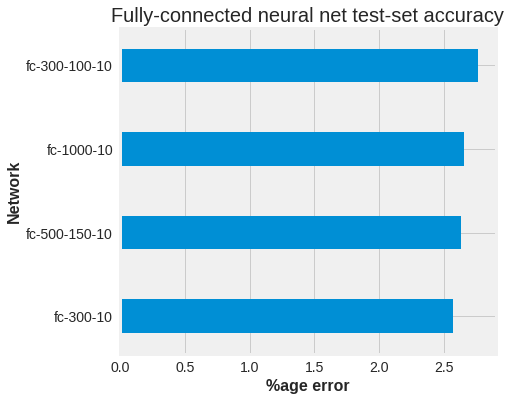

In [12]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
fc_scores_df.plot.barh(width=0.4, ax=ax, legend=None)
ax.set(title="Fully-connected neural net test-set accuracy", ylabel="Network", xlabel="%age error");
plt.savefig('fc_scores.png', bbox_inches='tight', dpi=150)

# Convolutional neural networks

Now let's see how much further we can improve performance with convolutional neural networks. For the convolutional networks, we need a 2-d image instead of the flattened 1-d vector the fully connected networks used. We also need to add padding around each of the images.

In [13]:
# Load image pickle files
X_train, y_train, X_test,  y_test = load_data()
X_train.shape

Loading pickle files


(60000, 28, 28)

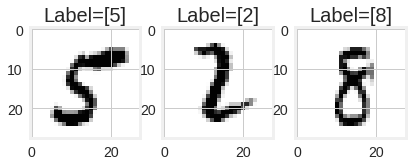

In [14]:
#Plot a few random numbers to sanity check their size and that they look correct
N = 3
indexes = np.random.choice(X_train.shape[0], N)
fig, ax = plt.subplots(1, N)

for num, idx in enumerate(indexes):
    ax[num].imshow(X_train[idx])
    ax[num].set(title="Label={}".format(y_train[idx]))

## Padding images to 32x32 while centering image

In [1], the images are padded to 32x32 to ensure every pixel of the input image ends up in the center of the receptive fields of the highest level feature receptors.

In [15]:
def image_border(image, size, fill):
    """
    Adds a border around the nupmy array of the gizen size and value
    """
    im_w, im_h = image.shape
    im_dtype = image.dtype
    
    new_image = np.full((im_w + (2 * size), im_h + (2 * size)),
                        fill_value=fill, dtype=im_dtype)
    new_image[size:im_h + size, size:im_w + size] = image
    
    assert new_image.dtype == image.dtype
    assert new_image.shape[0] == image.shape[0] + (2 * size)
    assert new_image.shape[1] == image.shape[1] + (2 * size)
    assert np.array_equal(image, new_image[size:size+im_h, size:size+im_w])
    return new_image

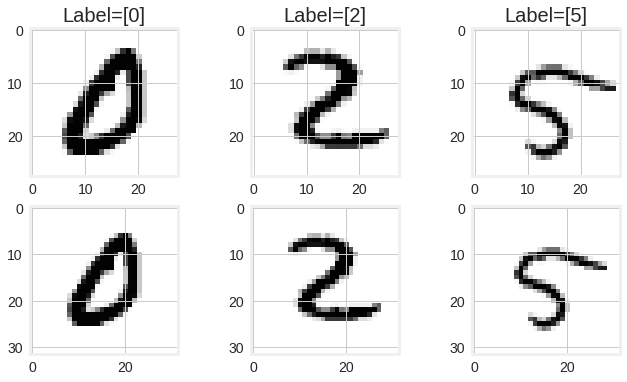

In [16]:
N = 3
indexes = np.random.choice(X_train.shape[0], N)
fig, ax = plt.subplots(2, N, figsize=(10,6))

for num, idx in enumerate(indexes):
    ax[0, num].imshow(X_train[idx])
    ax[0, num].set(title="Label={}".format(y_train[idx]))
    ax[1, num].imshow(image_border(X_train[idx], 2, 0))

In [17]:
from tqdm import tqdm

# resize all the training and test images
n_train = X_train.shape[0]
n_test = X_test.shape[0]


def resize_images(images, description):
    """
    Iterates through lowest order dimension, and resizes images
    """
    new_images = np.zeros((images.shape[0], 32, 32))

    for index in tqdm(range(images.shape[0]), desc=description):
        new_images[index] = image_border(images[index], 2, 0)
        
    return new_images

X_resize_train = resize_images(X_train, "Resizing train images")
X_resize_test = resize_images(X_test, "Resizing test images")
X_train, X_test = X_resize_train, X_resize_test

print('New X_train shape: {}, new x_test shape: {}'.format(X_train.shape, X_test.shape))
print('y_train shape: {}, y_test shape: {}'.format(y_train.shape, y_test.shape))

Resizing test images: 100%|██████████| 10000/10000 [00:00<00:00, 31649.89it/s]

New X_train shape: (60000, 32, 32), new x_test shape: (10000, 32, 32)
y_train shape: (60000, 1), y_test shape: (10000, 1)


## Z-Normalizing images, and converting labels to one-hot

In [18]:
from keras import backend as K

# Input images need to be Z-normalized, and need to be flattened to 1-d vector and re-squared afterwards
X_train, X_test = z_norm_X(flatten_images(X_train), flatten_images(X_test))
X_train, X_test = square_images(X_train, 32, 32), square_images(X_test, 32, 32)

# y values need to be converted to one-hot
y_train, y_test = onehot_encode_y(y_train, y_test)

# Need to add explicit shape of 1 as we have 1 channel for B&W images
X_train, X_test = X_train[:,:,:, np.newaxis], X_test[:,:,:, np.newaxis] # Need explicit single channel 

print('New X_train shape: {}, new x_test shape: {}'.format(X_train.shape, X_test.shape))
print('y_train shape: {}, y_test shape: {}'.format(y_train.shape, y_test.shape))

Z-normalizing X data..
Converting y variables to one-hot encoding..
New X_train shape: (60000, 32, 32, 1), new x_test shape: (10000, 32, 32, 1)
y_train shape: (60000, 10), y_test shape: (10000, 10)


In [19]:
# Our channels are in the least significant order of the np array (32, 32, 1). 
# Make sure the current backend matches this ordering, and doesn't expect (1, 32, 32).
assert K.image_data_format() == 'channels_last'

# LeNet-5

This is the best performing network, found on page 7 of [1].

In [20]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Activation, AveragePooling2D, Flatten

def lenet5_model(verbose=False):
    """
    Creates and returns a lenet5 model
    """

    # Create the model
    model = Sequential()

    model.add(Conv2D(filters=6, kernel_size=(5, 5), strides=(1, 1), input_shape=(32, 32, 1))) # C1
    model.add(AveragePooling2D(pool_size=(2, 2))) # S2
    model.add(Activation('tanh'))

    model.add(Conv2D(filters=16, kernel_size=(5, 5), strides=(1, 1))) # C3
    model.add(AveragePooling2D(pool_size=(2, 2))) # S4
    model.add(Activation('tanh'))

    model.add(Conv2D(filters=120, kernel_size=(5, 5), strides=(1, 1))) # C5
    model.add(Activation('tanh'))

    model.add(Flatten())
    model.add(Dense(120)) # F6
    model.add(Activation('tanh'))

    model.add(Dense(10))
    model.add(Activation('softmax'))

    if verbose:
        print(model.summary())
    return model
    
lenet5 = lenet5_model(verbose=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d_1 (Average (None, 14, 14, 6)         0         
_________________________________________________________________
activation_11 (Activation)   (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_2 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
activation_12 (Activation)   (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 1, 120)         48120     
__________

In [21]:
# Create a new model every time

def evaluate_model(model, optimizer, cv_split=None, verbose=False):
    """
    Wrapper method to create, train, and check performance on test set
    """

    if verbose:
        print('\nCompiling model')
        model.summary()
        
    model.compile(optimizer=optimizer,
                   loss='categorical_crossentropy', 
                   metrics=['accuracy'])

    if verbose:
        print('\nTraining model')
    history = model.fit(X_train, y_train, validation_split=cv_split, 
                        epochs=20, batch_size=256, verbose=1 if verbose else 0)

    if verbose:
        print('\nEvaluating model')
    score = model.evaluate(X_test, y_test, batch_size=256)

    if verbose:
        print('\nTest results: Loss = {:.4f}, Error = {:.4f}'.format(score[0], 1.0 - score[1]))
    
    results = {'model': model, 'history': history.history, 'loss': score[0], 'acc': score[1], 'err': 1.0 - score[1]}
    return results

results = evaluate_model(model=lenet5_model(),
                          optimizer=SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True),
                          cv_split=0.2, verbose=True)


Compiling model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d_3 (Average (None, 14, 14, 6)         0         
_________________________________________________________________
activation_16 (Activation)   (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_4 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
activation_17 (Activation)   (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 1, 1, 120)         4812

## Visualizing results

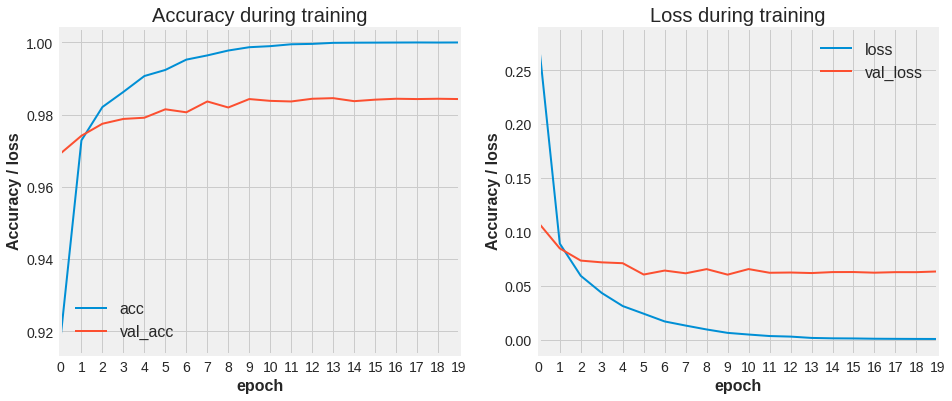

In [22]:
def plot_history(hist):
    """
    Plots the history object returned by the .fit() call
    """
    for metric in ('acc', 'loss', 'val_acc', 'val_loss'):
        assert metric in hist.keys()
    
    hist_df = pd.DataFrame(hist)
    fig, axes = plt.subplots(1,2,figsize=(14, 6))

    hist_df[['acc', 'val_acc']].plot.line(ax=axes[0])
    hist_df[['loss', 'val_loss']].plot.line(ax=axes[1])
    axes[0].set(title="Accuracy during training")
    axes[1].set(title="Loss during training")
    
    for ax in axes:
        ax.set_xticks(range(hist_df.shape[0]))
        ax.set(xlabel="epoch", ylabel="Accuracy / loss")
        
#     return fig, axes

plot_history(results['history'])

## Cross validation of optimizer

In [23]:
def random_sgd(verbose=False):
    """
    Generates an SGD optimizer with random values
    """
    lr = 10 ** np.random.randint(-6, -3)
    momentum = 0.1 * np.random.randint(8, 10)
    decay = 10 ** np.random.randint(-5, -3)
    nesterov = np.random.uniform() < 0.5
    
    sgd = SGD(lr=lr, momentum=momentum, decay=decay, nesterov=nesterov)
    if verbose:
        print('sgd: lr={}, momentum={}, decay={}, nesterov={}'.format(lr, momentum, decay, nesterov))
        
    return sgd
    
random_sgd(verbose=True)

sgd: lr=0.0001, momentum=0.8, decay=0.0001, nesterov=True


In [24]:
# Randomize optimizer and run for 100 samples
def best_model(N=100):
    """
    Returns the best model after random search for N SGD values
    """
    best_result = None
    best_acc = 0

    for n in range(N):
        print('\nIteration {}'.format(n))
        sgd_opt = random_sgd()
        result = evaluate_model(lenet5_model(), sgd_opt)
        current_acc = result['acc']
        
        if current_acc > best_acc:
            print('\n-> Updating best model. Current acc: {}, old acc: {}'.format(n, current_acc, best_acc))
            best_result = result
            best_acc = current_acc
    
    return result

# best_lenet5 = best_model(N=5)

# Modernizing the network - max-pooling, relu, and dropout

Since [1] was published, new layer types have been invented to improve ease-of training, and reduce overfitting. Let's retrofit the original network with these new improvements, and see how the performance changes.



In [25]:
from keras.models import Sequential
from keras.layers import MaxPooling2D, Dropout

def lenet5_modern_model(dropout_cnt=0, dropout_val=0.5, bias_init=None, verbose=False):
    """
    Creates and returns a lenet5 model with retrofitted modern layers:
    - ReLU activations
    - Max pooling
    - Dropout
    """

    # Create the model
    model = Sequential()

    if bias_init:
        bias = bias_init
    else:
        bias='zeros'
        
    model.add(Conv2D(filters=6, kernel_size=(5, 5), strides=(1, 1), 
                     input_shape=(32, 32, 1), bias_initializer=bias)) # C1
    model.add(MaxPooling2D(pool_size=(2, 2))) # S2
    model.add(Activation('relu'))
    if dropout_cnt >= 1:
        model.add(Dropout(dropout_val))
    
    model.add(Conv2D(filters=16, kernel_size=(5, 5), strides=(1, 1),
                    bias_initializer=bias)) # C3
    model.add(MaxPooling2D(pool_size=(2, 2))) # S4
    model.add(Activation('relu'))
    if dropout_cnt >= 2:
        model.add(Dropout(dropout_val))

    model.add(Conv2D(filters=120, kernel_size=(5, 5), strides=(1, 1),
                    bias_initializer=bias)) # C5
    model.add(Activation('relu'))
    if dropout_cnt >= 3:
        model.add(Dropout(dropout_val))

    model.add(Flatten())
    model.add(Dense(120)) # F6
    model.add(Activation('relu'))
    if dropout_cnt >= 4:
        model.add(Dropout(dropout_val))
    
    model.add(Dense(10))
    model.add(Activation('softmax'))

    if verbose:
        print(model.summary())
    return model
    
lenet5 = lenet5_modern_model(verbose=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
activation_21 (Activation)   (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
activation_22 (Activation)   (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 1, 120)         48120     
__________

In [29]:
%%time

results = dict()

RUNS = 3
scores = dict()
bias='zeros'

# Exhaustive grid search
for dropout_cnt in range(1, 4):
    for dropout_val in (0.1, 0.2, 0.3, 0.4, 0.5):
        print('\nTesting {} layer(s) of dropout, {} value '.format(dropout_cnt, dropout_val), end='')
        errors = np.zeros((RUNS,))
        for index in range(RUNS): # Run each combination multiple times
            
            result_idx = (index, bias, dropout_cnt, dropout_val)
            model = lenet5_modern_model(dropout_cnt=dropout_cnt, dropout_val=dropout_val)
            results[result_idx] = evaluate_model(model,
                                      optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),
                                      cv_split=None, verbose=False)

            error = 1.0 - results[result_idx]['acc']
            errors[index] = error

        run_idx = (bias, dropout_cnt, dropout_val)
        run_error = errors.mean()
        run_sd = errors.std()
        print('\nBias: {}, dropout: {} @ {}, error: {:.4f} ({:.4f} std dev)'.format(*run_idx, run_error, run_sd))



 7936/10000 [======================>.......] - ETA: 0s
Bias: zeros, dropout: 1 @ 0.1, error: 0.0098 (0.0004 std dev)

 7680/10000 [======================>.......] - ETA: 0s
Bias: zeros, dropout: 1 @ 0.2, error: 0.0109 (0.0003 std dev)

 7680/10000 [======================>.......] - ETA: 0s
Bias: zeros, dropout: 1 @ 0.3, error: 0.0094 (0.0002 std dev)

 9984/10000 [============================>.] - ETA: 0s
Bias: zeros, dropout: 1 @ 0.4, error: 0.0105 (0.0011 std dev)

 8960/10000 [=========================>....] - ETA: 0s
Bias: zeros, dropout: 1 @ 0.5, error: 0.0114 (0.0005 std dev)

 7168/10000 [====================>.........] - ETA: 0s
Bias: zeros, dropout: 2 @ 0.1, error: 0.0097 (0.0004 std dev)

 7424/10000 [=====================>........] - ETA: 0s
Bias: zeros, dropout: 2 @ 0.2, error: 0.0086 (0.0005 std dev)

 7168/10000 [====================>.........] - ETA: 0s
Bias: zeros, dropout: 2 @ 0.3, error: 0.0102 (0.0004 std dev)

 8448/10000 [========================>.....] - ETA: 0s


In [27]:
# Randomized hyper parameter search
def random_params(seed=None, verbose=False):
    """
    Generates random parameters for a cross validation run
    """
    if seed:
        np.random.seed(seed)
        
    params = dict()
    params['bias_init'] = "zeros"
    params['dropout_val'] = np.random.uniform(low=0.01, high=0.3)
    params['dropout_cnt'] = np.random.randint(low=0, high=3)
    
    if verbose:
        print("bias: {bias_init}, dropout cnt: {dropout_val}, dropout val: {dropout_cnt}".format(**params))
    return params

random_params(verbose=True)

bias: zeros, dropout cnt: 0.24072596354053313, dropout val: 2


{'bias_init': 'zeros', 'dropout_cnt': 2, 'dropout_val': 0.24072596354053313}

In [28]:
best_error_mean = 100
best_error_sd = 100

improvement_error_mean = 0

THRESH = 0.01 # Keep searching until we can't 
THRESH_N = 5

# while improvement_error_mean > THRESH:

params = random_params(verbose=True)
evaluate_model(model=lenet5_modern_model(**params),
                                      optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),
                                      cv_split=0.2, verbose=True)


bias: zeros, dropout cnt: 0.09035997402122727, dropout val: 2

Compiling model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
activation_26 (Activation)   (None, 14, 14, 6)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 16)          0         
_______________________________________________________________

KeyboardInterrupt: 

# Image augmentation 

Plot the CV error and test error as a function of the training set size. Note the gap to motivate the image augmentation approach.

# Ensembling models

Train multiple models, keep the ones with the least correlation and take mojority vote from them.

# 